In [16]:
from datetime import datetime
import os
import re

# Get the current directory
current_directory = os.getcwd()

# Regular expression to extract the [name] portion
pattern = r'(\d+)_(.*?)_(\d{2}_\d{2}_\d{4}_\d{2}_\d{2}_\d{2})\.log'

# Create a dictionary to store filenames by [name]
name_to_files = {}

# List all files with a .log extension in the current directory
log_files = [file for file in os.listdir(current_directory) if file.endswith(".log")]


# Function to parse the timestamp string into a datetime object
def parse_timestamp(timestamp_str):
    return datetime.strptime(timestamp_str, '%d_%m_%Y_%H_%M_%S')


# Iterate through log files and group them by [name]
for log_file in log_files:
    match = re.search(pattern, log_file)
    if match:
        name = match.group(2)
        timestamp_str = match.group(3)
        timestamp = parse_timestamp(timestamp_str)

        if name not in name_to_files:
            name_to_files[name] = []
        name_to_files[name].append((timestamp, log_file))

# Print the grouped filenames
for name, files in name_to_files.items():
    print(f"[name]: {name}")
    sorted_files = sorted(files, key=lambda x: x[0])  # Sort by timestamp
    for _, file in sorted_files:
        print(file)

[name]: VIRAT_S_040000_04_000532_000622_
0_VIRAT_S_040000_04_000532_000622__20_10_2023_05_08_55.log
1_VIRAT_S_040000_04_000532_000622__20_10_2023_05_13_06.log
2_VIRAT_S_040000_04_000532_000622__20_10_2023_05_17_23.log
3_VIRAT_S_040000_04_000532_000622__20_10_2023_05_21_37.log
4_VIRAT_S_040000_04_000532_000622__20_10_2023_05_25_48.log
5_VIRAT_S_040000_04_000532_000622__20_10_2023_05_30_03.log
6_VIRAT_S_040000_04_000532_000622__20_10_2023_05_34_17.log
7_VIRAT_S_040000_04_000532_000622__20_10_2023_05_38_32.log
8_VIRAT_S_040000_04_000532_000622__20_10_2023_05_42_48.log
9_VIRAT_S_040000_04_000532_000622__20_10_2023_05_47_04.log
[name]: VIRAT_S_050201_00_000012_000116_
0_VIRAT_S_050201_00_000012_000116__20_10_2023_02_48_03.log
1_VIRAT_S_050201_00_000012_000116__20_10_2023_02_51_57.log
2_VIRAT_S_050201_00_000012_000116__20_10_2023_02_55_59.log
3_VIRAT_S_050201_00_000012_000116__20_10_2023_02_59_59.log
4_VIRAT_S_050201_00_000012_000116__20_10_2023_03_04_00.log
5_VIRAT_S_050201_00_000012_000116

In [17]:
import numpy as np


class InputSet:
    def __init__(self, height, width, ):
        self.event_bitrate = None
        self.adder_features = np.zeros((height, width), dtype=bool)
        self.adder_time = None
        self.cv_features = np.zeros((height, width), dtype=bool)
        self.cv_time = None
        self.psnr = None
        self.mse = None
        self.ssim = None

    def total_adder(self):
        return np.sum(self.adder_features.astype(int))

    def total_cv(self):
        return np.sum(self.cv_features.astype(int))


def process_entry(entry, input_sets):
    if 's' in entry:
        if "OpenCV" in entry['s']:
            input_sets[-1].cv_features[entry['y'], entry['x']] = True
        elif "ADDER" in entry['s']:
            input_sets[-1].adder_features[entry['y'], entry['x']] = True
        else:
            raise Exception("Malformed entry")
    elif 'psnr' in entry:
        input_sets[-1].psnr = entry['psnr']
        input_sets[-1].mse = entry['mse']
        input_sets[-1].ssim = entry['ssim']


import pickle


def read_logfile(path):
    objects = []
    with (
            open(
                path,
                "rb")) as openfile:
        # Read the dimensions
        dims = openfile.readline().decode('UTF-8')
        # print(dims)
        width = int(dims.split('x')[0])
        height = int(dims.split('x')[1])
        channels = int(dims.split('x')[2])

        dbg_lines = 0
        input_interval_idx = 0
        input_sets = [InputSet(height, width)]

        while True:
            try:
                entry = pickle.load(openfile)
                if type(entry) == str and "ADDER FAST:" in entry:
                    # The start of a new interval
                    time = entry.split(': ')[1]
                    input_sets[-1].adder_time = int(time)
                    continue
                elif type(entry) == str and "bps:" in entry:
                    # The bitrate
                    # The end of the interval
                    bitrate = float(entry.split(': ')[1]) / 1024.0 / 1024.0
                    input_sets[-1].event_bitrate = bitrate

                    input_sets += [InputSet(height, width)]
                    input_interval_idx += 1
                    continue
                elif type(entry) == str and "OpenCV FAST:" in entry:
                    time = entry.split(': ')[1]
                    input_sets[-1].cv_time = int(time)

                elif type(entry) == str and "META:" in entry:
                    # print(entry)
                    continue
                else:
                    process_entry(entry, input_sets)

                    # print(entry)
                    dbg_lines += 1
                    # if dbg_lines == 100000:
                    #     break
            except pickle.UnpicklingError:
                line = openfile.readline().decode('UTF-8')
                if "Ticks per second" in line:
                    tps = int(line.split(': ')[2])
                elif "ticks per source interval" in line:
                    tpf = int(line.split(': ')[2])
                # print(line)
            except EOFError:
                break

        # Remove the last item because it might have none values
        input_sets = input_sets[:-1]
        return input_sets


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3


def feature_count_plot_all(sets):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    for i, input_sets in enumerate(sets):
        adder_feature_count = [obj.total_adder() for obj in input_sets]
        cv_feature_count = [obj.total_cv() for obj in input_sets]

        sns.lineplot(x=range(len(input_sets) - 1), y=adder_feature_count[:-1], marker=None, label="ADDER_" + str(i))
        sns.lineplot(x=range(len(input_sets) - 1), y=cv_feature_count[:-1], marker=None, label="OpenCV_" + str(i))

    plt.ylabel("# features")
    plt.xlabel("Input frame")
    plt.title("Feature count over time")
    plt.show()
    # interactive_plot = mpld3.display()
    # interactive_plot


def feature_speed_plot_all(sets):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    for i, input_sets in enumerate(sets):
        adder_times = [obj.adder_time for obj in input_sets]
        cv_times = [obj.cv_time for obj in input_sets]

        sns.lineplot(x=range(len(input_sets)), y=adder_times, marker=None, label="ADDER_" + str(i))
        sns.lineplot(x=range(len(input_sets)), y=cv_times, marker=None, label="OpenCV_" + str(i))
    plt.ylabel("Time (ns)")
    plt.xlabel("Input frame")
    plt.yscale('log')
    plt.title("Feature detection speed")

    plt.show()
    # interactive_plot = mpld3.display()
    # interactive_plot

    cv_mean = np.mean(np.array(cv_times))
    adder_mean = np.mean(np.array(adder_times))
    percent_change = (adder_mean / cv_mean) - 1
    print('OpenCV mean:', cv_mean, '  Median:', np.median(np.array(cv_times)))
    print('ADDER mean:', adder_mean, "({:.1f}%)".format(percent_change * 100), '  Median:',
          np.median(np.array(adder_times)))


def bitrates_plot_all(sets):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    for i, input_sets in enumerate(sets):
        adder_bitrates = [obj.event_bitrate for obj in input_sets]

        total_adder_size = np.sum(adder_bitrates) / (tps / tpf)
        print(total_adder_size, "Mb")

        source_raw_Mbps = (width * height * channels * (tps / tpf) * 8.0) / 1024.0 / 1024.0
        total_raw_size = (width * height * channels * len(adder_bitrates) * 8.0) / 1024.0 / 1024.0
        print(total_raw_size, "Mb")
        framed_bitrates = [source_raw_Mbps for obj in input_sets]

        sns.lineplot(x=range(len(input_sets)), y=adder_bitrates, marker=None, label="ADDER_" + str(i))
        sns.lineplot(x=range(len(input_sets)), y=framed_bitrates, marker=None, label="OpenCV_" + str(i))
    plt.ylabel("Raw bitrate (Mb/s)")
    plt.xlabel("Input frame")
    # plt.yscale('log')
    plt.title("Bitrate")

    plt.show()


def quality_plot_all(sets):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    for i, input_sets in enumerate(sets):
        adder_psnr = [obj.psnr for obj in input_sets]
        adder_ssim = [obj.ssim for obj in input_sets]

        sns.lineplot(x=range(len(input_sets)), y=adder_psnr, marker=None, label="PSNR_" + str(i))
        sns.lineplot(x=range(len(input_sets)), y=adder_ssim, marker=None, label="SSIM_" + str(i))
    plt.ylabel("Score")
    plt.xlabel("Input frame")
    # plt.yscale('log')
    plt.title("Quality metrics")

    plt.show()

[name]: VIRAT_S_040000_04_000532_000622_
960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 0

META: c_thresh_baseline: 0

META: c_thresh_max: 0

META: c_increase_velocity: 10
960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 1

META: c_thresh_baseline: 0

META: c_thresh_max: 3

META: c_increase_velocity: 9
960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 2

META: c_thresh_baseline: 1

META: c_thresh_max: 5

META: c_increase_velocity: 8
960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 3

META: c_thresh_baseline: 2

META: c_thresh_max: 7

META: c_increase_velocity: 7
960x540x1

META: Ticks per second: 7642

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 4

META: c_thresh_bas

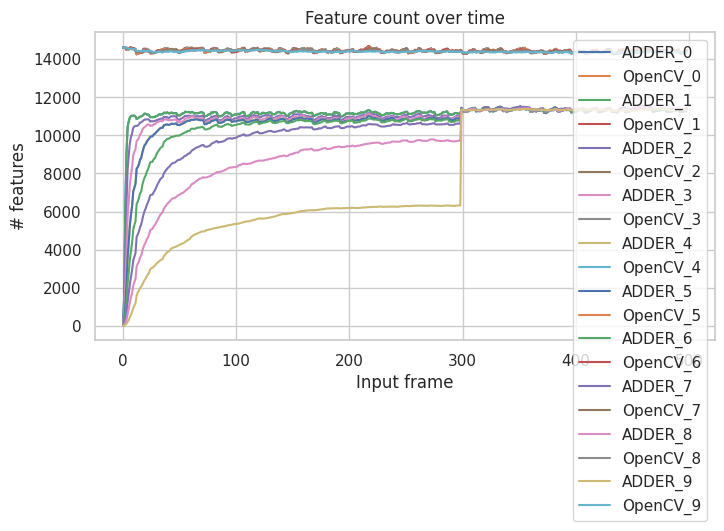

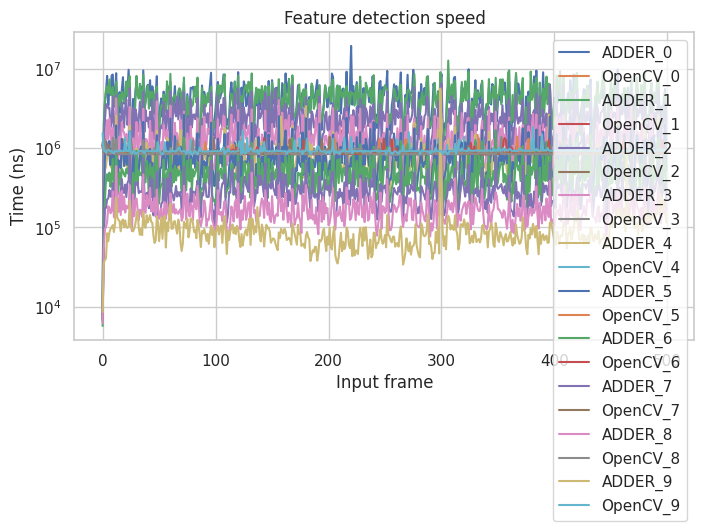

OpenCV mean: 931717.49   Median: 916568.0
ADDER mean: 101703.248 (-89.1%)   Median: 82840.0


<Figure size 800x400 with 0 Axes>

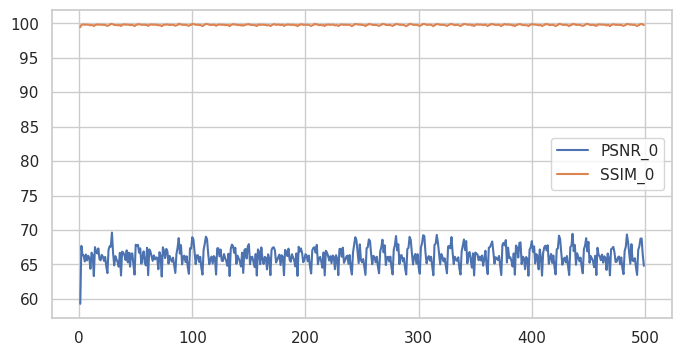

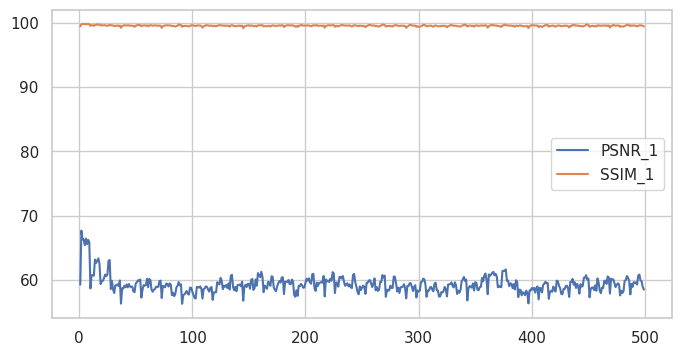

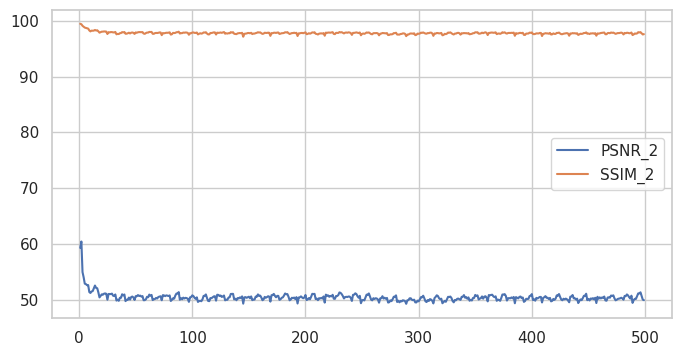

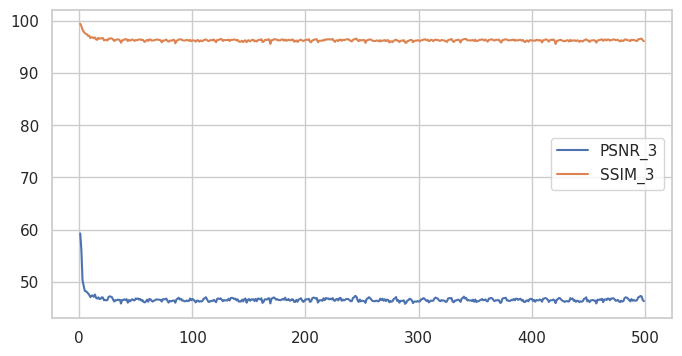

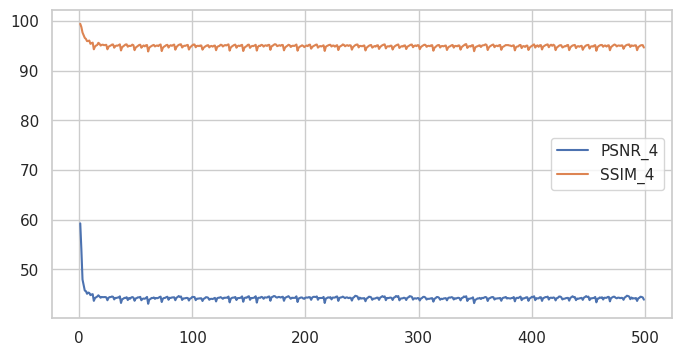

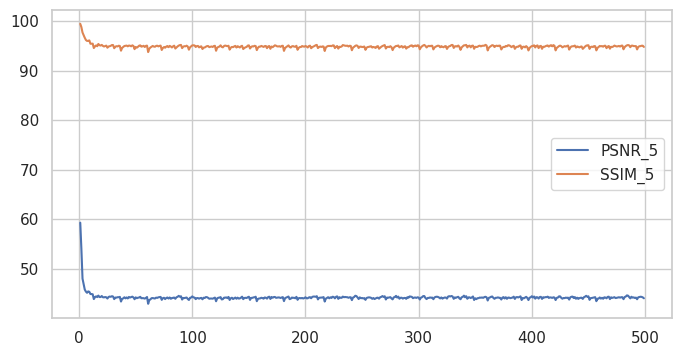

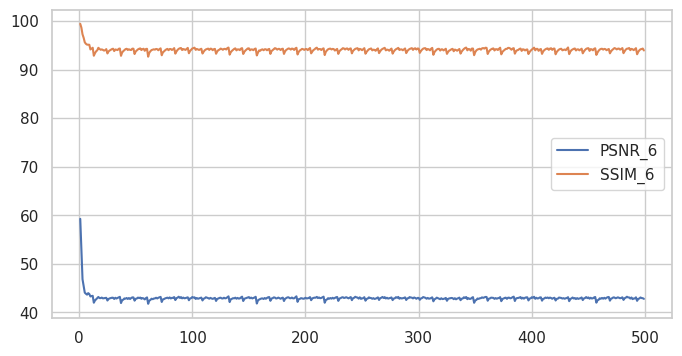

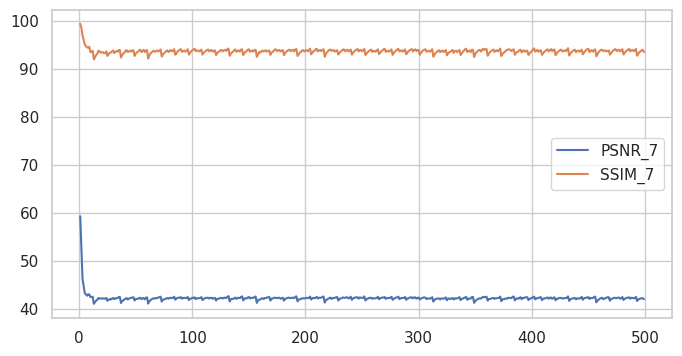

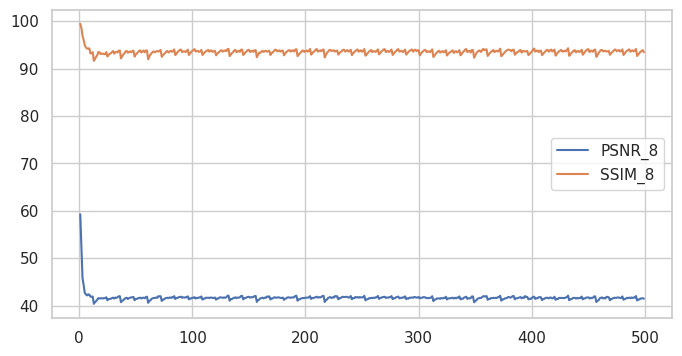

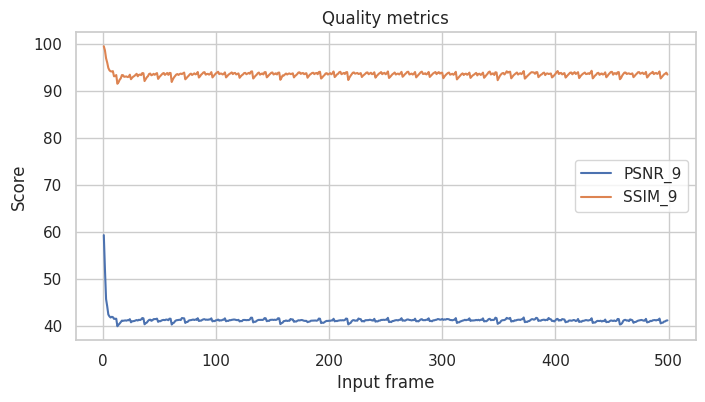

In [31]:
for name, files in name_to_files.items():
    print(f"[name]: {name}")
    sorted_files = sorted(files, key=lambda x: x[0])  # Sort by timestamp
    current_input_sets = []
    for _, file in sorted_files:
        current_input_sets = current_input_sets + [read_logfile(file)]
        # break

    feature_count_plot_all(current_input_sets)
    feature_speed_plot_all(current_input_sets)
    # bitrates_plot_all(current_input_sets)
    quality_plot_all(current_input_sets)
    break